# Exercício 3 - Lista Final - Fundamentos de Redes Neurais e Aprendizado Estatístico

Imports:

In [1]:
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

2024-08-27 14:50:07.336559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 14:50:07.766031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 14:50:07.922814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 14:50:07.967446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 14:50:08.247525: I tensorflow/core/platform/cpu_feature_guar

### Pré Processamento

Carregando conjunto de dados:

In [2]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas carros e aviões:

In [3]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Plotando imagem:

In [4]:
# função para plotar imagem exemplo posteriormente
def plot_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

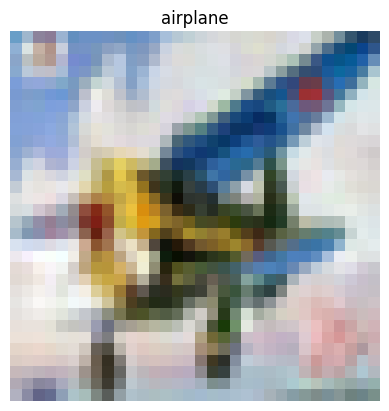

In [5]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 1254
example_image = x_filt[num_imagem]
example_label = y_filt[num_imagem][0]

plot_image(example_image, category_labels[example_label])

Convertendo para cinza:

In [6]:
def convert_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

In [7]:
x_all_gray = convert_to_gray(x_filt)

Vetorizando:

In [8]:
x_all_gray_flattened = x_all_gray.reshape(x_all_gray.shape[0], -1)

Conferindo formato:

In [10]:
print(f'Formato original das imagens: {x_filt.shape[1:]}')
print(f'Formato das imagens após conversão para cinza: {x_all_gray.shape[1:]}')
print(f'Formato das imagens vetorizadas: {x_all_gray_flattened.shape[1]}')

Formato original das imagens: (32, 32, 3)
Formato das imagens após conversão para cinza: (32, 32)
Formato das imagens vetorizadas: 1024


Limitando o conjunto de dados:

In [11]:
x_all_gray_flattened.shape

(12000, 1024)

In [12]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_all_gray_flattened, y_filt, test_size=1-sample_size, random_state=42)
X_sample.shape

(1200, 1024)

Escalando os dados:

In [13]:
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

Dividindo dados e embaralhando:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_scaled, y_sample, test_size=0.3, random_state=42, shuffle=True)

Olhando a distribuição do conjunto de testes:

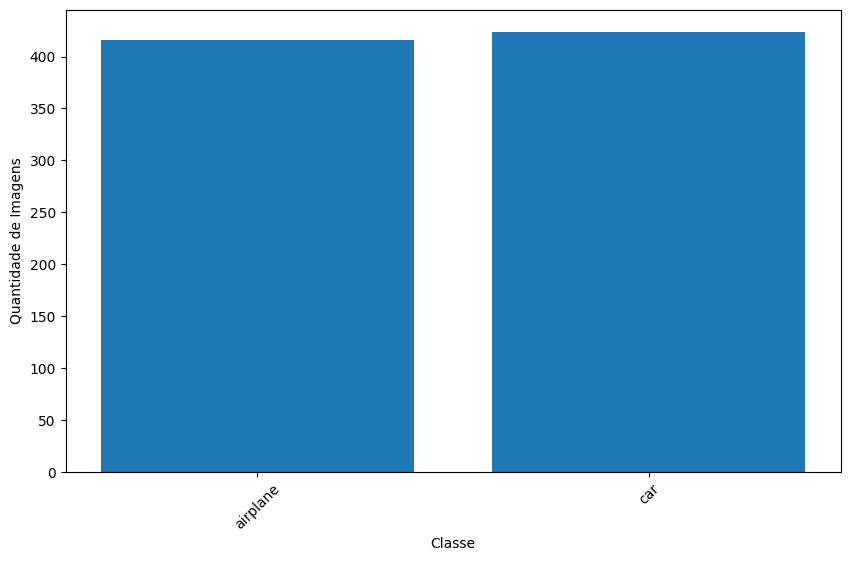

In [15]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['airplane', 'car']

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()

### Aplicando PCA

In [16]:
pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(X_train)

Coloca o conjunto de treino na dimensão do pca:

In [17]:
X_test_pca = pca.transform(X_test)

Plotando:

In [19]:
def plot_kpca(x, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x[:, 3], x[:, 4], c=y.ravel(), cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

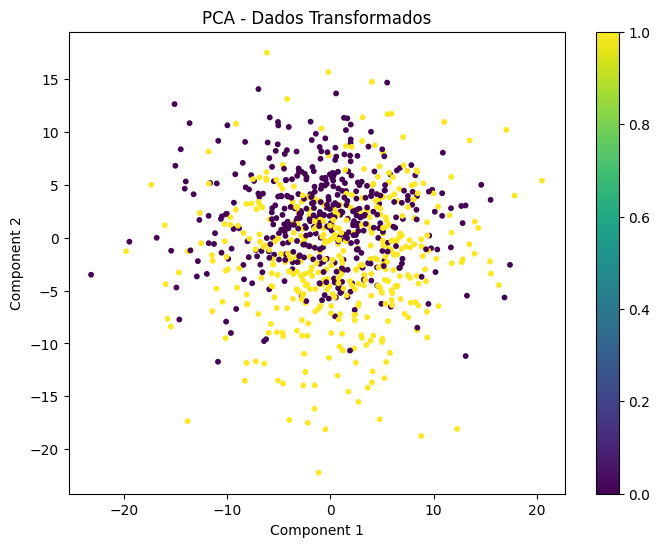

In [20]:
plot_kpca(x_train_pca, y_train, 'PCA - Dados Transformados')

Treina o LDA:

In [22]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
lda = []

# itera sobre cada fold
for fold, (train_index, test_index) in enumerate(kf1.split(x_train_pca)):
    
    X_train2, X_val = x_train_pca[train_index], x_train_pca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit(X_train2, y_train2.ravel()).transform(X_train2)

    # Avaliando o modelo
    y_pred1 = lda.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred1)
    print(f"Acurácia do LDA no conjunto de validação para o fold {fold+1}: {accuracy:.2f}")

    y_pred2 = lda.predict(X_test_pca)
    accuracy2 = accuracy_score(y_test, y_pred2)
    print(f"Acurácia do LDA no conjunto de testes para o fold {fold+1}: {accuracy2:.2f}")

    print("====================================================================================")

Acurácia do LDA no conjunto de validação para o fold 1: 0.75
Acurácia do LDA no conjunto de testes para o fold 1: 0.74
Acurácia do LDA no conjunto de validação para o fold 2: 0.70
Acurácia do LDA no conjunto de testes para o fold 2: 0.75
Acurácia do LDA no conjunto de validação para o fold 3: 0.71
Acurácia do LDA no conjunto de testes para o fold 3: 0.77
Acurácia do LDA no conjunto de validação para o fold 4: 0.74
Acurácia do LDA no conjunto de testes para o fold 4: 0.76
